# [E-05] House Price Prediction
"Exploration Node 5. My First Kaggle Competition" / 2022. 01. 24 (Mon) 이형주

## Contents
---
- **1. 문제의 정의**
- **2. 데이터 탐색 및 시각화**
- **3. 데이터 모델링**
- **4. 결과 및 회고** 

## Rubric 평가기준
---

|  평가문항  |  상세기준  |
|:---------|:---------|
|1. 캐글 데이터분석 전과정이 성공적으로 진행되었는가?|데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 진행되었다.
|2. 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?|제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.
|3. 회귀모델 예측정확도가 기준 이상 높게 나왔는가?|다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다.

## 1. 문제의 정의

+ 집이 가진 특성 정보를 기반으로 집값을 예측하는 회귀(Regression) 문제
+ 평가 방법: RMSE (평균 제곱근 오차)
    * 쉽게 말해, 실제 값과 예측 값의 차이가 적을 수록 좋은 것이다. (결과값이 작을수록 좋음)
        - 그래서 Private Score 110,000 이하를 요구한 것으로 보인다.
    * 평균 제곱오차에 루트를 씌운 이유는 연산 속도를 높이기 위함이다.

In [1]:
# Loading packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from scipy.stats import norm 
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import gc

import os
from os.path import join
import missingno as msno

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
import lightgbm as lgb

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data/'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

## 2. 데이터 탐색 및 시각화

**변수 설명**

_[원 자료 Source: [EDA] House Price Prediction 변수 + EDA (진행중)](https://www.kaggle.com/cookierhkwk/eda-house-price-prediction-eda?scriptVersionId=12305839)_

- ID : 집을 구분하는 번호
- date : 집을 구매한 날짜
- price : 집의 가격(Target variable)
- bedrooms : 침실의 수
- bathrooms : 침실 개수 당 화장실의 수(화장실의 수 / 침실의 수 )
- sqft_living : 주거 공간의 평방 피트(면적)
- sqft_lot : 부지의 평방 피트(면적)
- floors : 집의 층 수
- waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
- view : 집이 얼마나 좋아 보이는지의 정도
- condition : 집의 전반적인 상태
- grade : King County grading 시스템 기준으로 매긴 집의 등급
- sqft_above : 지하실을 제외한 평방 피트(면적)
- sqft_basement : 지하실의 평방 피트(면적)
- yr_built : 지어진 년도
- yr_renovated : 집을 재건축한 년도
- zipcode : 우편번호
- lat : 위도
- long : 경도
- sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
- sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

In [3]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


**변수 분석 및 가설 설정**

+ **date & price:** [구매 당시의 주택 비용](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/discussion/83957)이므로, 재건축(yr_renovated) 여부와 상관 없이 변동이 없는 것이다.
+ **bathroom :** 화장실 갯수에 소숫점이 있다. 해외 콘텐츠를 찾아본 결과 우리나라와는 다르게 화장실이 건식 형태로서 기본을 갖추고 있고 [파우더룸 등 구성에 따라 quarter(1/4) 단위의 수량으로](https://www.homenish.com/average-size-bathroom/) 세는 것 같다. 참고로만 넘긴다.
+ **lat, long :** 위도, 경도. 집값에 많은 영향을 미칠 것으로 판단되는 지표이다.
+ **grade:** Head 값만으로는 dramatic한 변화는 없을 것으로 보인다.
+ **yr_renovated :** 0 => 재건축된 이력이 없음일 것이다.
+ **sqft_living, sqft_living15 :** 두 수치간 차이가 제법 크다. 눈여겨 보아야겠다.

**시각화 및 정규화**

+ **price 분포 확인**
    - 왼쪽으로 많이 치우친 형태
    - log를 취하여 정규성을 가지도록 함

<AxesSubplot:xlabel='price', ylabel='Density'>

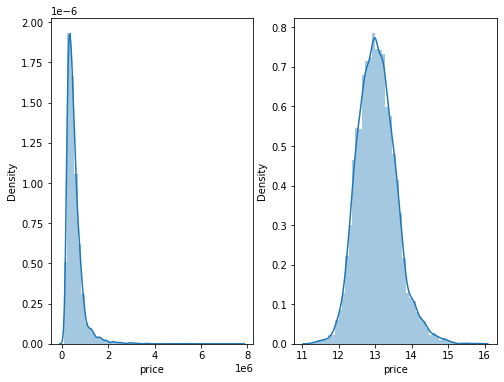

In [4]:
y = train['price']
y_log_transformation = np.log1p(y)

f, ax = plt.subplots(figsize = (8, 6))
plt.subplot(121)
sns.distplot(y)
plt.subplot(122)
sns.distplot(y_log_transformation)

+ **price와 가장 상관관계가 높은 순서대로 10개를 추려낸 히트맵**
    - grade -> sqft_living -> sqft_living15 -> sqft_above -> bathrooms -> lat
    - grade, sqft_living, bathrooms 변수들에게 비정상적인 수치들이 있을 확률이 높을 것으로 가정

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

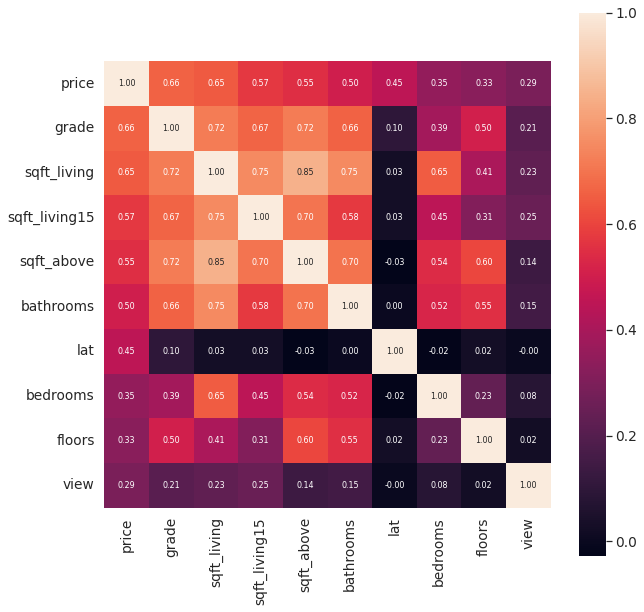

In [5]:
import scipy as sp

cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

## 3. 데이터 모델링

In [17]:
random_state=2010

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

def RMSE(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

def SCORE_RESULTS(models, train, y):
    df = {}
    
    for model in models:
        # 모델 이름
        model_name = model.__class__.__name__
        # train, test 데이터셋 분리
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        # 학습
        model.fit(X_train, y_train)
        # 예측
        y_pred = model.predict(X_test)
        # rmse 저장
        df[model_name] = rmse(y_test, y_pred)
        # data frame 저장
        Score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return Score_df

SCORE_RESULTS(models, train, y)

,RMSE
RandomForestRegressor,129393.187979
GradientBoostingRegressor,125991.077550
XGBRegressor,111600.332482
LGBMRegressor,110171.302076


In [19]:
def GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    grid_model.fit(train, y)

    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    results = pd.DataFrame(params)
    results['score'] = score
    
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
}
model = LGBMRegressor(random_state=random_state)
GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


,max_depth,n_estimators,score,RMSLE
5,20,300,-0.026091,0.161527
8,30,300,-0.026091,0.161527
2,10,300,-0.026127,0.161640
1,10,200,-0.026188,0.161828
4,20,200,-0.026245,0.162003
7,30,200,-0.026245,0.162003
0,10,100,-0.027027,0.164399
3,20,100,-0.027051,0.164472
6,30,100,-0.027051,0.164472


In [20]:
#model LGBMRegressor
model = LGBMRegressor(max_depth=30, n_estimators=300, random_state=random_state)
model.fit(train, y)

LGBMRegressor(max_depth=30, n_estimators=300, random_state=2010)

In [21]:
prediction_lgbm = model.predict(test)
prediction_lgbm = np.expm1(prediction_lgbm)
prediction_lgbm

array([ 499619.74521686,  490052.17258291, 1397838.90879818, ...,
        465269.55869982,  318564.30877008,  450157.90324192])

In [23]:
#model XGBRegressor
xgb_model = XGBRegressor(max_depth=30, n_estimators=300, random_state=random_state)
xgb_model.fit(train, y)

prediction_xgb = xgb_model.predict(test)
prediction_xgb

array([13.233772, 12.987459, 13.97934 , ..., 13.055232, 12.687863,
       12.973543], dtype=float32)

In [24]:
prediction_xgb = np.expm1(prediction_xgb)
prediction_xgb

array([ 558924.94,  436898.8 , 1178011.9 , ...,  467535.2 ,  323793.2 ,
        430861.  ], dtype=float32)

In [25]:
#numpy array combination (average)
#source1: https://ponyozzang.tistory.com/507
#source2: https://www.delftstack.com/ko/api/numpy/python-numpy-mean/
lgbm_xgb_combination = np.vstack([prediction_xgb, prediction_lgbm]).mean()

In [33]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)

submission['price'] = lgbm_xgb_combination
submission.head()

,id,price
0,15035,529048.57593
1,15036,529048.57593
2,15037,529048.57593
3,15038,529048.57593
4,15039,529048.57593


In [35]:
submission_path_csv = '{}/submission.csv'.format(data_dir)
submission.to_csv(submission_path_csv, index=False)
print(submission_path_csv)

/aiffel/aiffel/kaggle_kakr_housing/data/submission.csv


## 4. 결과 및 회고

+ 루브릭에서 요구하는 기준으로는 110,000점 이하의 점수는 물론이고, 너무 높은 Score가 기록되었다.
    - 접근 과정에서의 오류보다는 각 모델에 대입할 값을 너무 적게 책정한 것이 원인으로 생각이 된다.
        + param_grid를 더 다양하게 구성하면 점수를 크게 낮출 수 있을 것으로 기대된다.
    - 이 문제를 해결하기 위해서 모델링을 LightGBM, XGBoost, Linear Regression으로 바꾸었을 때는 해결이 되었지만, 루브릭 요구기준에는 충족하지 못하므로 삭제하였다.
    - Number of features of the model must match... 오류가 발생하여 아래 두 자료를 참고하여 40번 이상 시도 후 해결하였다.
        + [StackOverFlow](https://stackoverflow.com/questions/44026832/valueerror-number-of-features-of-the-model-must-match-the-input)
        + [Inflearn](https://www.inflearn.com/questions/94467)
+ 어떤 데이터를 정제하면 더 좋은 결과가 나올 수 있는지에 대해서는 파악할 수 있었던 것 같다.
+ 현재까지는 다른 사람의 코드를 검색할 수 있다고 해도, 가급적 노드 안에서 답을 찾으려고만 노력하는 것이 오히려 효율성을 저해할 수 있다는 동기의 피드백을 받았다. 따라서 다음 노드 진행부터는 코드를 적극 참고하되 어떻게 하면 자신의 것으로 바꾸고 설명할 수 있을지 방향성을 전환할 예정이다.

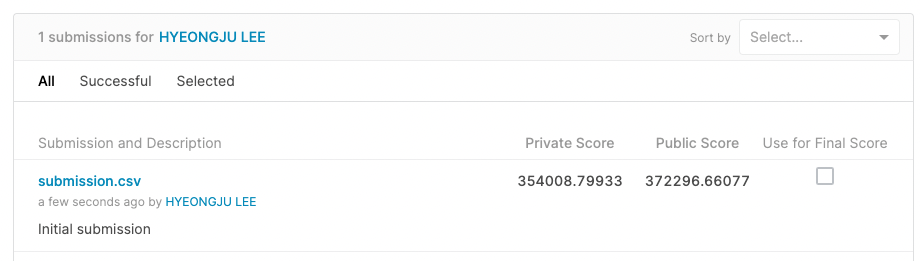